Total messages loaded: 22582
20180
<class 'list'>
['Вини полез спорить с игроком просто так']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasyarussu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['вини полезть спорить игрок']
Pipeline components are ready for BERTopic.


  0%|          | 0/1 [00:00<?, ?it/s]/Users/anastasyarussu/Documents/thesis_hse/data+code/code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anastasyarussu/Documents/thesis_hse/data+code/code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anastasyarussu/Documents/thesis_hse/data+code/code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anastasyarussu/Documents/thesis_hse

nr_topics=20 => Coherence Score (c_v): 0.6799415273561188, (u_mass): -0.5222124386094336, IRBO: None, Avg Cosine Similarity: 0.4369825841155979


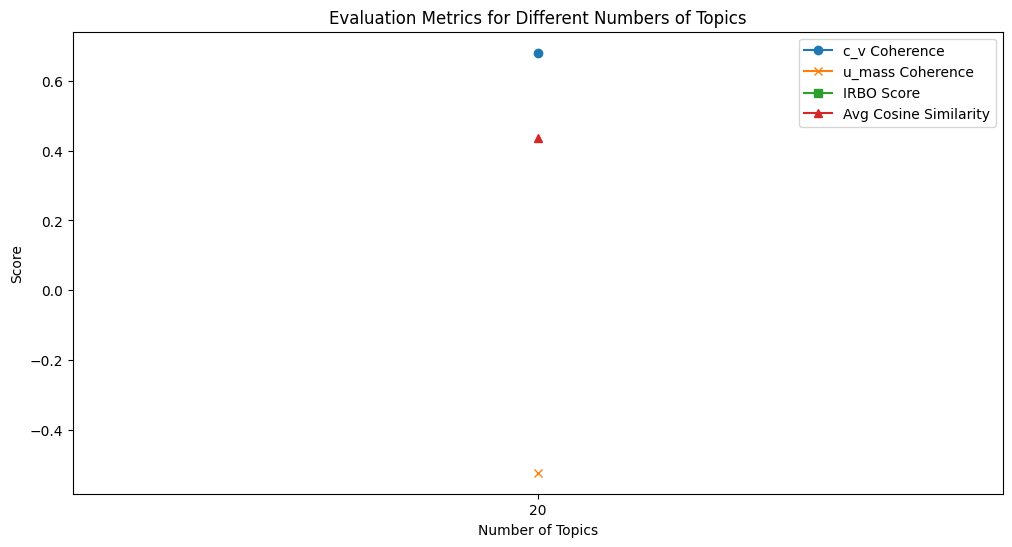

In [7]:
import pandas as pd
import json
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from nltk.corpus import stopwords
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim import corpora
import re
import os
import pymorphy2  # Russian lemmatizer
from razdel import tokenize  # Better tokenization for Russian
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
from urllib3.exceptions import NotOpenSSLWarning
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# ... [Your data loading and preprocessing code remains unchanged] ...
# Load the JSON file
json_file = '/Users/anastasyarussu/Documents/thesis_hse/data+code/code/dataset_barca_30k/barka_30k_filtered_messages.json'

def load_messages(json_file):
    messages = []
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if isinstance(data, list):
                for item in data:
                    msg = item.get('text', '')
                    if isinstance(msg, str):  # If it's a string, add directly
                        messages.append(msg)
                    elif isinstance(msg, list):  # If it's a list, process elements
                        combined_message = []
                        for part in msg:
                            if isinstance(part, str):  # Add string parts directly
                                combined_message.append(part)
                            elif isinstance(part, dict):  # Extract 'text' from dict
                                text_part = part.get('text', '')
                                if isinstance(text_part, str):
                                    combined_message.append(text_part)
                        messages.append(' '.join(combined_message))  # Join all parts
            else:
                print("Unsupported JSON structure. Expected a list.")
        print(f"Total messages loaded: {len(messages)}")
    except FileNotFoundError:
        print(f"The file {json_file} was not found.")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    return messages
messages = load_messages(json_file)
df = pd.DataFrame(messages, columns=["message"])

# Convert JSON to DataFrame and extract the 'message' field

df = df[df['message'].notnull() & (df['message'] != '')]  # Filter non-null and non-empty messages

# Convert messages to a list for BERTopic
documents = df['message'].tolist()

# Verifications similar to the cookbook notebook
print(len(documents))  # Number of messages
print(type(documents))  # Data type
print(documents[:1])  # First instance of the content

# Load stop words for Russian
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

# Stop phrases to exclude
stop_phrases = [
    "у меня", "я не", "так и не", "до сих пор", "и не", "не знаю", "не будет",
    "о том что", "мороженое увеличил карму", "увеличил карму", "добавить карма", "карма", 
    'это', 'еще', 'ещё', 'очень', 'неа', 'есс', 'вообще', 'просто', 'вроде'
]

# Initialize Russian lemmatizer
morph = pymorphy2.MorphAnalyzer()

# Preprocess the dataset
filtered_text = []

for message in documents:
    # Convert to lowercase
    message = message.lower()

    # Remove stop phrases
    for phrase in stop_phrases:
        message = message.replace(phrase, "")

    # Tokenize the Russian text using razdel
    tokens = [token.text for token in tokenize(message)]

    # Remove punctuation and non-alphabetic tokens
    tokens = [re.sub(r'\W+', '', token) for token in tokens if token.isalpha()]

    # Lemmatize and filter out stopwords
    lemmatized_tokens = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if token not in russian_stopwords and len(token) > 2
    ]

    lemmatized_message = " ".join(lemmatized_tokens)

    # Remove English words using regex
    lemmatized_message = re.sub(r'\b[A-Za-z]+\b', '', lemmatized_message)

    # Strip extra whitespace and append
    if lemmatized_message.strip():
        filtered_text.append(lemmatized_message.strip())

print(filtered_text[:1])  # Check the first preprocessed message
# Step 2.1 - Extract embeddings using a multilingual SentenceTransformer
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine")


# Step 2.3 - Cluster reduced embeddings with HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=15, metric="euclidean", cluster_selection_method="eom", prediction_data=True)

# Step 2.4 - Tokenize topics with CountVectorizer (adapted for Russian)
vectorizer_model = CountVectorizer(stop_words=russian_stopwords)
ctfidf_model = ClassTfidfTransformer()
# Step 2.5 - Create topic representation with ClassTFIDFTransformer
# ... [Your other pipeline components remain unchanged] ...

print("Pipeline components are ready for BERTopic.")

# Define a range of topic numbers to evaluate
topic_numbers = [20]

coherence_scores_cv = []
coherence_scores_umass = []
irbo_scores = []
average_cosine_similarities = []

# Store topic-word distributions for IRBO computation
previous_topic_word_distributions = None

for nr_topics in tqdm(topic_numbers):
    # Create a new BERTopic model with the specified number of topics
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        nr_topics=nr_topics
    )
    
    # Fit the model to the filtered text
    topics, probabilities = topic_model.fit_transform(filtered_text)
    
    # Prepare documents for topic analysis
    documents = pd.DataFrame({
        "Document": filtered_text,
        "ID": range(len(filtered_text)),
        "Topic": topics
    })
    
    # Aggregate documents per topic for coherence evaluation
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)
    
    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    # Tokenize the cleaned documents for coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    
    # Create a dictionary and corpus for Gensim coherence evaluation
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    
    # Extract topic words for each topic
    topic_words = [
        [words for words, _ in topic_model.get_topic(topic)]
        for topic in range(len(set(topics)) - 1)
        if topic_model.get_topic(topic)  # Ensure the topic is not empty
    ]
    
    # Evaluate coherence using the 'c_v' metric
    coherence_model_cv = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_cv = coherence_model_cv.get_coherence()
    coherence_scores_cv.append(coherence_cv)
    
    # Evaluate coherence using the 'u_mass' metric
    coherence_model_umass = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='u_mass'
    )
    coherence_umass = coherence_model_umass.get_coherence()
    coherence_scores_umass.append(coherence_umass)
    
    # Calculate IRBO if previous topic-word distributions exist
    current_topic_word_distributions = topic_model.get_topic_info()
    if previous_topic_word_distributions is not None:
        # Compute IRBO between previous and current topic models
        # Here we use Jaccard similarity as a placeholder for IRBO computation
        # You may need to implement or use a library function for exact IRBO calculation
        overlap_scores = []
        for prev_topic_words in previous_topic_word_distributions['Name']:
            prev_words_set = set(prev_topic_words.split('_'))
            max_overlap = 0
            for curr_topic_words in current_topic_word_distributions['Name']:
                curr_words_set = set(curr_topic_words.split('_'))
                overlap = len(prev_words_set & curr_words_set) / len(prev_words_set | curr_words_set)
                max_overlap = max(max_overlap, overlap)
            overlap_scores.append(max_overlap)
        irbo_score = np.mean(overlap_scores)
        irbo_scores.append(irbo_score)
    else:
        irbo_scores.append(None)  # No IRBO score for the first iteration

    # Update previous topic-word distributions
    previous_topic_word_distributions = current_topic_word_distributions

    # Calculate average cosine similarity between topic embeddings
    topic_embeddings = topic_model.topic_embeddings_
    if topic_embeddings is not None and len(topic_embeddings) > 1:
        cosine_sim_matrix = cosine_similarity(topic_embeddings)
        # Exclude self-similarity by masking the diagonal
        np.fill_diagonal(cosine_sim_matrix, np.nan)
        average_cosine_similarity = np.nanmean(cosine_sim_matrix)
        average_cosine_similarities.append(average_cosine_similarity)
    else:
        average_cosine_similarities.append(None)

    print(f"nr_topics={nr_topics} => Coherence Score (c_v): {coherence_cv}, (u_mass): {coherence_umass}, IRBO: {irbo_scores[-1]}, Avg Cosine Similarity: {average_cosine_similarities[-1]}")

# Plot the coherence scores
plt.figure(figsize=(12, 6))
plt.plot([str(n) for n in topic_numbers], coherence_scores_cv, marker='o', label='c_v Coherence')
plt.plot([str(n) for n in topic_numbers], coherence_scores_umass, marker='x', label='u_mass Coherence')
plt.plot([str(n) for n in topic_numbers], irbo_scores, marker='s', label='IRBO Score')
plt.plot([str(n) for n in topic_numbers], average_cosine_similarities, marker='^', label='Avg Cosine Similarity')
plt.title('Evaluation Metrics for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.legend()
plt.show()


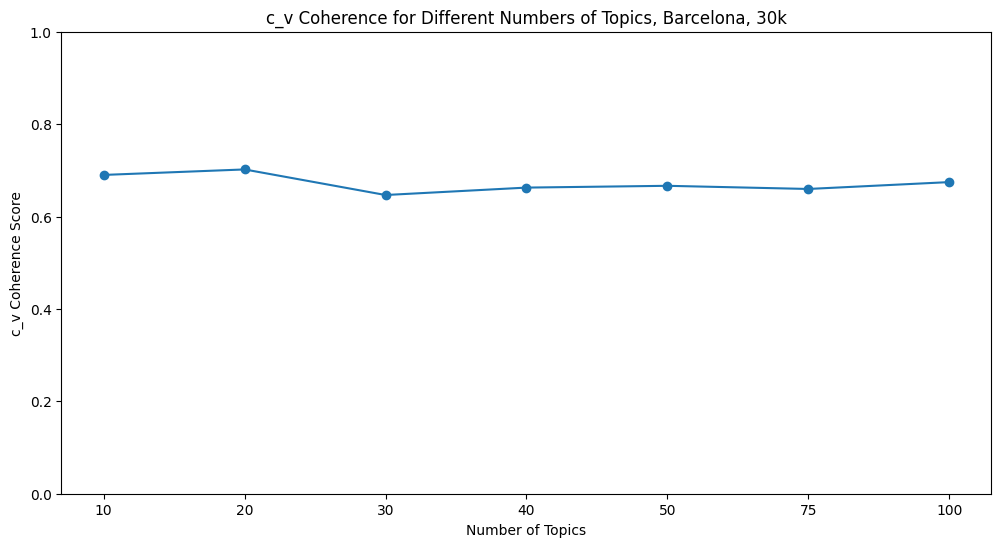

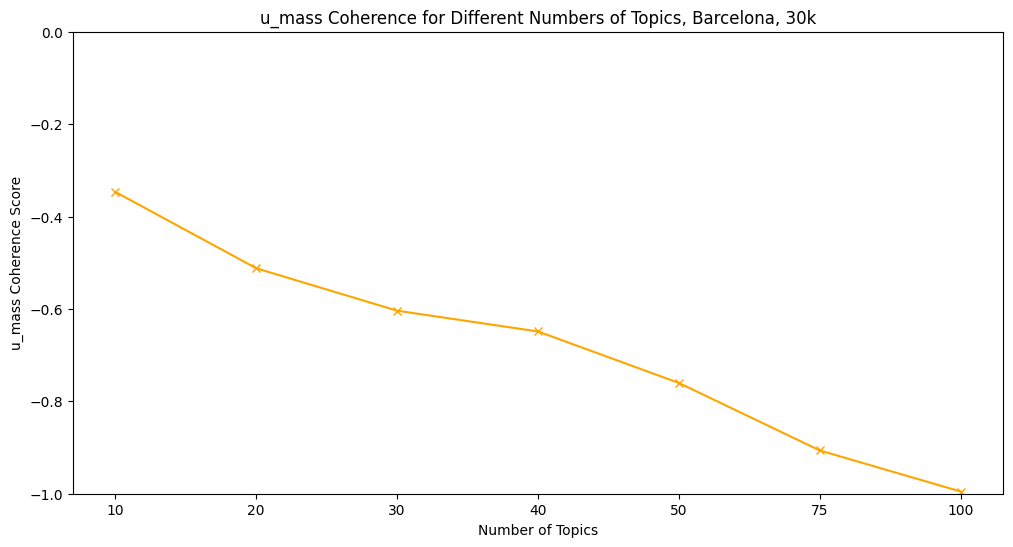

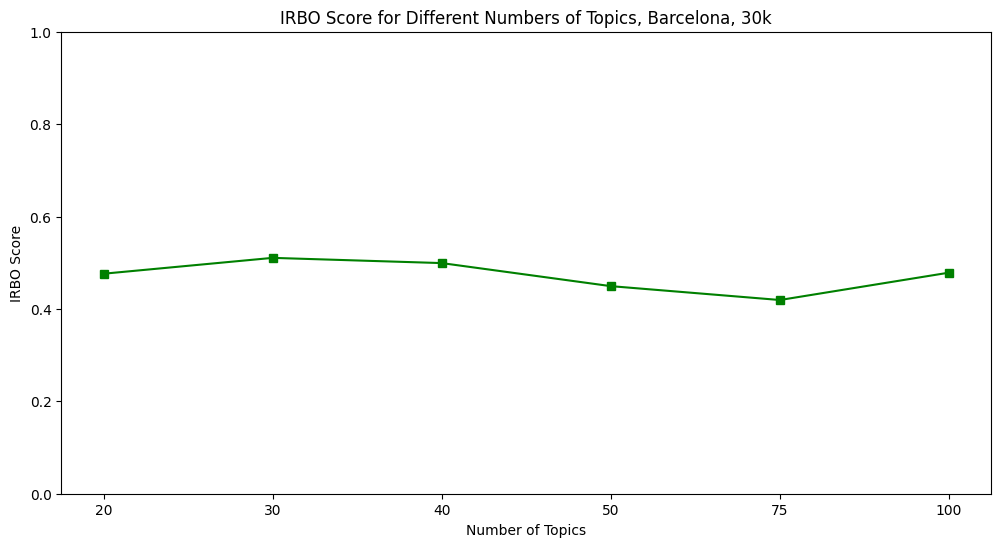

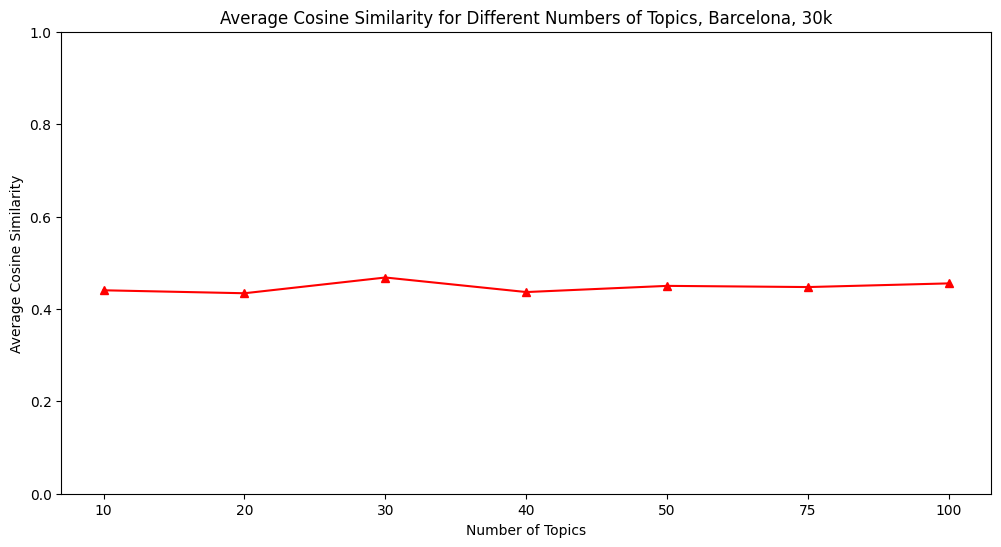

In [5]:
import matplotlib.pyplot as plt

# Assuming the data is already defined
# topic_numbers, coherence_scores_cv, coherence_scores_umass, irbo_scores, average_cosine_similarities

# Plot for c_v Coherence
plt.figure(figsize=(12, 6))
plt.ylim([0,1])
plt.plot([str(n) for n in topic_numbers], coherence_scores_cv, marker='o')
plt.title('c_v Coherence for Different Numbers of Topics, Barcelona, 30k')
plt.xlabel('Number of Topics')
plt.ylabel('c_v Coherence Score')
plt.ylim([0,1])
plt.show()

# Plot for u_mass Coherence
plt.figure(figsize=(12, 6))
plt.ylim([-1,0])
plt.plot([str(n) for n in topic_numbers], coherence_scores_umass, marker='x', color='orange')
plt.title('u_mass Coherence for Different Numbers of Topics, Barcelona, 30k')
plt.xlabel('Number of Topics')
plt.ylabel('u_mass Coherence Score')

plt.show()

# Plot for IRBO Score
plt.figure(figsize=(12, 6))
plt.ylim([0,1])
plt.plot([str(n) for n in topic_numbers], irbo_scores, marker='s', color='green')
plt.title('IRBO Score for Different Numbers of Topics, Barcelona, 30k')
plt.xlabel('Number of Topics')
plt.ylabel('IRBO Score')

plt.show()

# Plot for Average Cosine Similarity
plt.figure(figsize=(12, 6))
plt.ylim([0,1])
plt.plot([str(n) for n in topic_numbers], average_cosine_similarities, marker='^', color='red')
plt.title('Average Cosine Similarity for Different Numbers of Topics, Barcelona, 30k')
plt.xlabel('Number of Topics')
plt.ylabel('Average Cosine Similarity')

plt.show()


In [8]:


# Visualize the generated topics
topic_model.visualize_topics().show()

# Visualize the top topics in a bar chart
topic_model.visualize_barchart(top_n_topics=10).show()  # Adjust `top_n_topics` as needed
